In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# EDA

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords,wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score,accuracy_score

from wordcloud import WordCloud,STOPWORDS
from collections import Counter,defaultdict
from PIL import Image
import spacy
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.5/en_core_web_sm-2.2.5.tar.gz
import en_core_web_sm    

import random
import warnings
import time
import datetime

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpathces

import torch
from transformers import BertTokenizer,BertForSequenceClassification,AdamW,BertConfig,get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset,random_split,DataLoader,RandomSampler,SequentialSampler

stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 68.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.5-py3-none-any.whl size=12011738 sha256=a8a2d341cadcc1ac52109130723a80ab74db7e1b98af81a01695a4a6a3bc015b
  Stored in directory: /root/.cache/pip/wheels/51/19/da/a3885266a3c241aff0ad2eb674ae058fd34a4870fef1c0a5a0
Successfully built en-core-web-sm
  Attemptin

/opt/conda/lib/python3.7/site-packages/spacy/util.py:885: UserWarning: [W094] Model 'en_core_web_sm' (2.2.5) specifies an under-constrained spaCy version requirement: >=2.2.2. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.5.0,<3.6.0
  warnings.warn(warn_msg)


## Loading the Data

In [3]:
trainv = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
testv = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [4]:
display(trainv.sample(5))
display(testv.sample(5))

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


,id,keyword,location,text
142,449,armageddon,1996???????????,UNIVERSAL ORDER OF ARMAGEDDON http://t.co/3tY4mGm
2672,8915,snowstorm,Los Angeles,@BigBang_CBS ...wow...ok...um...that was like ...
2605,8682,sinkhole,"New York, New York",The sinkhole that ate Brooklyn http://t.co/28r...
2515,8381,ruin,"Monroe, OH",Don't ruin a good today by thinking about a ba...
958,3187,deluge,"West Powelton, Philadelphia",I'm havin previous life flashbacks of when i l...


In [5]:
print(trainv.shape)
print(testv.shape)

(7613, 5)
(3263, 4)


## Cleaning Text

In [6]:
def remove_URL(text):
    url = re.compile(r'https?:\\/S+|www\.S+')
    return url.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

trainv['text_clean'] = trainv['text'].apply(lambda x: remove_URL(x))
trainv['text_clean'] = trainv['text_clean'].apply(lambda x: remove_emoji(x))
trainv['text_clean'] = trainv['text_clean'].apply(lambda x: remove_html(x))
trainv['text_clean'] = trainv['text_clean'].apply(lambda x: remove_punct(x))

In [7]:
trainv['tokenized'] = trainv['text_clean'].apply(word_tokenize)
trainv.head()

,id,keyword,location,text,target,text_clean,tokenized
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala..."


In [8]:
trainv['lower'] = trainv['tokenized'].apply(
    lambda x: [word.lower() for word in x])
trainv.head()

,id,keyword,location,text,target,text_clean,tokenized,lower
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala..."


In [9]:
trainv['stopwords_removed'] = trainv['lower'].apply(
    lambda x: [word for word in x if word not in stop])

trainv.head()

,id,keyword,location,text,target,text_clean,tokenized,lower,stopwords_removed
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [10]:
trainv['pos_tags'] = trainv['stopwords_removed'].apply(nltk.tag.pos_tag)
trainv.head()

,id,keyword,location,text,target,text_clean,tokenized,lower,stopwords_removed,pos_tags
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N..."


In [11]:
!python3 -m nltk.downloader wordnet
!unzip /root/nltk_data/corpora/wordnet.zip -d /root/nltk_data/corpora/

/opt/conda/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
unzip:  cannot find or open /root/nltk_data/corpora/wordnet.zip, /root/nltk_data/corpora/wordnet.zip.zip or /root/nltk_data/corpora/wordnet.zip.ZIP.


In [12]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [13]:
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

print(f'Number of training tweets: {train.shape[0]}\n')
print(f'Number of training tweets: {test.shape[0]}\n')

display(train.sample(10))

Number of training tweets: 7613

Number of training tweets: 3263



,id,keyword,location,text,target
217,309,annihilated,"Greater Manchester, UK",@ACarewornHeart Have a good un fella sorry I w...,0
6688,9582,thunder,NaN,Thunder lightening torrential rain and a power...,1
2687,3855,detonation,NaN,Dorman 917-033 Ignition Knock (Detonation) Sen...,1
5060,7211,natural%20disaster,liaÛ¢daniÛ¢laura,Rise up like a natural disaster we take the ba...,0
6855,9826,trauma,NaN,Trauma injuries involving kids and sport usual...,1
563,814,battle,NaN,A young German stormtrooper engaged in the Bat...,1
2431,3493,derailed,United Kingdom,#tubestrike derailed you? Our #robertwelch cut...,0
2928,4209,drowned,NaN,@ABCNews24 @PeterDutton_MP \nHe also told you....,0
3400,4868,explode,London / Berlin / Online,'I eat because it makes my mouth explode with ...,0
6258,8942,storm,NaN,FINALLY a storm,0


In [14]:
labels = train['target'].values
idx = len(labels)
combined = pd.concat([train, test])
combined = combined.text.values

In [15]:
combined

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       ..., 'Green Line derailment in Chicago http://t.co/UtbXLcBIuY',
       'MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3',
       '#CityofCalgary has activated its Municipal Emergency Plan. #yycstorm'],
      dtype=object)

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

In [17]:
print(' Original: ', combined[0])

# Print the tweet split into tokens.

print('Tokenized: ', tokenizer.tokenize(combined[0]))

# Print the sentence mapped to token ID's.

print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(combined[0])))

 Original:  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Tokenized:  ['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']
Token IDs:  [2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035]


In [18]:
max_len = 0

for text in combined:
    input_ids = tokenizer.encode(text,add_special_tokens=True)
    max_len = max(max_len,len(input_ids))
print('Max sentence length:',max_len)

Max sentence length: 84


In [19]:
token_lens = []

for text in combined:
    tokens = tokenizer.encode(text,max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


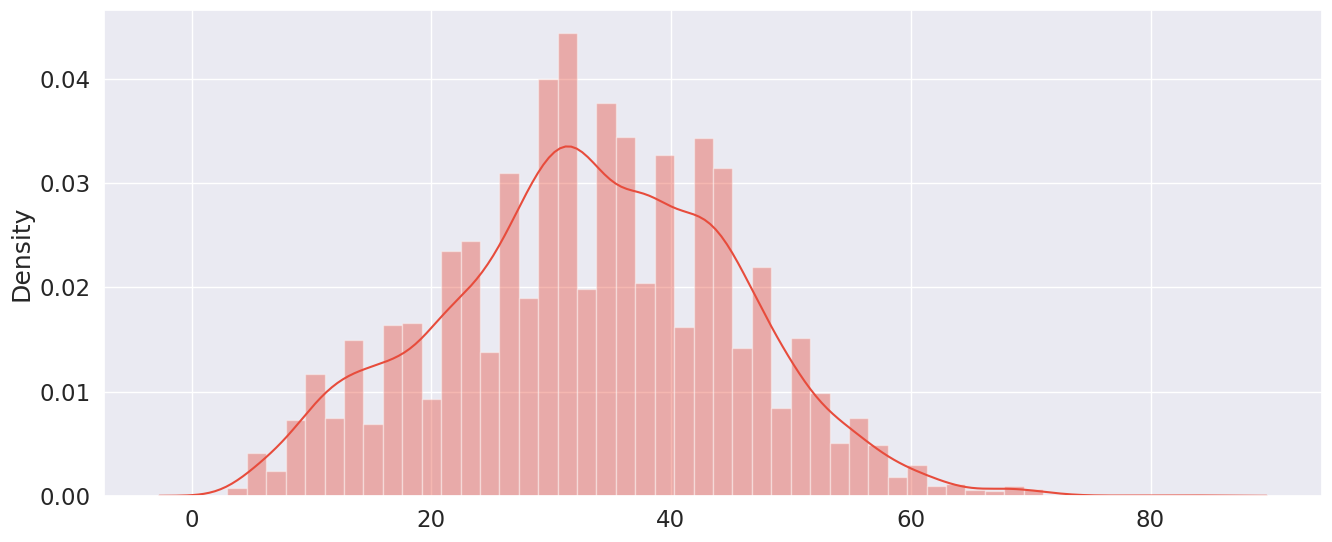

In [20]:
fig,axes = plt.subplots(figsize=(14,6))
sns.distplot(token_lens,color='#e74c3c')
plt.show()

In [21]:
train = combined[:idx]
test = combined[idx:]
train.shape

(7613,)

In [22]:
def tokenize_map(sentence,labs='None'):
    global labels
    input_ids = []
    attention_masks = []
    
    for text in sentence:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            truncation='longest_first',
            max_length=84,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids,dim=0)
    attention_masks = torch.cat(attention_masks,dim=0)
    
    if labs != 'None':
        labels = torch.tensor(labels)
        return input_ids,attention_masks,labels
    else:
        return input_ids,attention_masks

In [23]:
input_ids,attention_masks,labels = tokenize_map(train,True)
test_input_ids,test_attention_masks = tokenize_map(test)

In [24]:
dataset = TensorDataset(input_ids,attention_masks,labels)
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size

train_dataset,valid_dataset = random_split(dataset,[train_size,valid_size])

print('train samples',len(train_dataset))
print('valid samples',len(valid_dataset))

train samples 6090
valid samples 1523


In [25]:
batch_size = 32

train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size = batch_size)

valid_dataloader = DataLoader(
    valid_dataset,
    sampler = SequentialSampler(valid_dataset),
    batch_size = batch_size)

In [26]:
prediction_data = TensorDataset(test_input_ids,test_attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data,sampler=prediction_sampler,batch_size=batch_size)

In [27]:
model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels = 2,
        output_attentions = False,
        output_hidden_states = False)

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [28]:
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
for p in params[0:5]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (768,)
bert.encoder.layer.0.

In [29]:
optimizer = AdamW(model.parameters(),
                 lr = 6e-6,
                 eps = 1e-8)

In [30]:
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                           num_training_steps=total_steps)

In [31]:
def flat_accuracy(preds,labels):
    pred_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat,pred_flat)

def flat_f1(preds,labels):
    pred_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat,pred_flat)

In [32]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [33]:
from tqdm.auto import tqdm
training_stats = []
total_t0 = time.time()

for epoch in range(epochs):
    print('')
    print(f"========= Epoch {epoch+1} / {epochs} ===========")
    print('Training....')
    
    t0 = time.time()
    total_train_loss = 0
    model.train()
    
    for step,batch in enumerate(tqdm(train_dataloader)):
        if step % 50 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
    
        batch_input_ids = batch[0].to(device).to(torch.int64)
        batch_attention_mask = batch[1].to(device).to(torch.int64)
        batch_labels = batch[2].to(device).to(torch.int64)

        optimizer.zero_grad()

        output = model(batch_input_ids,
                            token_type_ids=None,
                            attention_mask=batch_attention_mask,
                            labels=batch_labels)
        loss,logits = output[0],output[1]

        total_train_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm(model.parameters(),1.0)
        optimizer.step()
        scheduler.step()
        
    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)
    
    print('')
    print('  Average training loss: {0:.2f}'.format(avg_train_loss))
    print('  Training epcoh took: {:}'.format(training_time))

    
    print('')
    print('Running Validation...')
    
    t0 = time.time()
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    total_eval_f1 = 0
    nb_eval_steps = 0
    for batch in tqdm(valid_dataloader):
        batch_input_ids = batch[0].to(device)
        batch_attention_mask = batch[1].to(device)
        batch_labels = batch[2].to(device)
        
        with torch.no_grad():
            output = model(batch_input_ids,
                               token_type_ids=None,
                               attention_mask=batch_attention_mask,
                               labels=batch_labels)
            loss,logits = output[0],output[1]
            total_eval_loss += loss.item()
            logits = logits.detach().cpu().numpy()
            label_ids = batch_labels.to('cpu').numpy()

            total_eval_accuracy += flat_accuracy(logits,label_ids)
            total_eval_f1 += flat_f1(logits,label_ids)
        avg_val_accuracy = total_eval_accuracy / len(valid_dataloader)
        print('  Accuracy: {0:.2f}'.format(avg_val_accuracy))
        avg_val_f1 = total_eval_f1 / len(valid_dataloader)
        print('  F1: {0:.2f}'.format(avg_val_f1))
        avg_val_loss = total_eval_loss / len(valid_dataloader)
        validation_time = format_time(time.time() - t0)

        print('  Validation Loss: {0:.2f}'.format(avg_val_loss))
        print('  Validation took: {:}'.format(validation_time))

    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Val_F1' : avg_val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    
print('')
print('Training Complete!')

print('Total training took {:} (h:mm:ss)'.format(format_time(time.time()-total_t0)))


========= Epoch 1 / 3 ===========
Training....


  0%|          | 0/191 [00:00<?, ?it/s]

  Batch    50  of    191.    Elapsed: 0:00:16.
  Batch   100  of    191.    Elapsed: 0:00:29.
  Batch   150  of    191.    Elapsed: 0:00:43.

  Average training loss: 0.52
  Training epcoh took: 0:00:54

Running Validation...


  0%|          | 0/48 [00:00<?, ?it/s]

  Accuracy: 0.01
  F1: 0.02
  Validation Loss: 0.01
  Validation took: 0:00:00
  Accuracy: 0.03
  F1: 0.03
  Validation Loss: 0.02
  Validation took: 0:00:00
  Accuracy: 0.05
  F1: 0.05
  Validation Loss: 0.03
  Validation took: 0:00:00
  Accuracy: 0.07
  F1: 0.07
  Validation Loss: 0.04
  Validation took: 0:00:00
  Accuracy: 0.09
  F1: 0.09
  Validation Loss: 0.04
  Validation took: 0:00:00
  Accuracy: 0.10
  F1: 0.10
  Validation Loss: 0.05
  Validation took: 0:00:01
  Accuracy: 0.12
  F1: 0.12
  Validation Loss: 0.06
  Validation took: 0:00:01
  Accuracy: 0.14
  F1: 0.14
  Validation Loss: 0.07
  Validation took: 0:00:01
  Accuracy: 0.16
  F1: 0.15
  Validation Loss: 0.08
  Validation took: 0:00:01
  Accuracy: 0.17
  F1: 0.17
  Validation Loss: 0.09
  Validation took: 0:00:01
  Accuracy: 0.19
  F1: 0.18
  Validation Loss: 0.10
  Validation took: 0:00:01
  Accuracy: 0.21
  F1: 0.20
  Validation Loss: 0.11
  Validation took: 0:00:01
  Accuracy: 0.22
  F1: 0.22
  Validation Loss: 0.12


  0%|          | 0/191 [00:00<?, ?it/s]

  Batch    50  of    191.    Elapsed: 0:00:14.
  Batch   100  of    191.    Elapsed: 0:00:27.
  Batch   150  of    191.    Elapsed: 0:00:41.

  Average training loss: 0.40
  Training epcoh took: 0:00:52

Running Validation...


  0%|          | 0/48 [00:00<?, ?it/s]

  Accuracy: 0.01
  F1: 0.02
  Validation Loss: 0.01
  Validation took: 0:00:00
  Accuracy: 0.03
  F1: 0.03
  Validation Loss: 0.02
  Validation took: 0:00:00
  Accuracy: 0.05
  F1: 0.05
  Validation Loss: 0.03
  Validation took: 0:00:00
  Accuracy: 0.07
  F1: 0.06
  Validation Loss: 0.04
  Validation took: 0:00:00
  Accuracy: 0.09
  F1: 0.09
  Validation Loss: 0.04
  Validation took: 0:00:00
  Accuracy: 0.10
  F1: 0.10
  Validation Loss: 0.05
  Validation took: 0:00:01
  Accuracy: 0.12
  F1: 0.12
  Validation Loss: 0.06
  Validation took: 0:00:01
  Accuracy: 0.14
  F1: 0.13
  Validation Loss: 0.07
  Validation took: 0:00:01
  Accuracy: 0.15
  F1: 0.15
  Validation Loss: 0.08
  Validation took: 0:00:01
  Accuracy: 0.17
  F1: 0.17
  Validation Loss: 0.09
  Validation took: 0:00:01
  Accuracy: 0.19
  F1: 0.18
  Validation Loss: 0.10
  Validation took: 0:00:01
  Accuracy: 0.20
  F1: 0.20
  Validation Loss: 0.11
  Validation took: 0:00:01
  Accuracy: 0.22
  F1: 0.21
  Validation Loss: 0.12


  0%|          | 0/191 [00:00<?, ?it/s]

  Batch    50  of    191.    Elapsed: 0:00:14.
  Batch   100  of    191.    Elapsed: 0:00:27.
  Batch   150  of    191.    Elapsed: 0:00:41.

  Average training loss: 0.36
  Training epcoh took: 0:00:52

Running Validation...


  0%|          | 0/48 [00:00<?, ?it/s]

  Accuracy: 0.01
  F1: 0.02
  Validation Loss: 0.02
  Validation took: 0:00:00
  Accuracy: 0.03
  F1: 0.03
  Validation Loss: 0.02
  Validation took: 0:00:00
  Accuracy: 0.05
  F1: 0.05
  Validation Loss: 0.03
  Validation took: 0:00:00
  Accuracy: 0.07
  F1: 0.06
  Validation Loss: 0.04
  Validation took: 0:00:00
  Accuracy: 0.09
  F1: 0.08
  Validation Loss: 0.04
  Validation took: 0:00:00
  Accuracy: 0.10
  F1: 0.10
  Validation Loss: 0.05
  Validation took: 0:00:01
  Accuracy: 0.12
  F1: 0.12
  Validation Loss: 0.06
  Validation took: 0:00:01
  Accuracy: 0.14
  F1: 0.13
  Validation Loss: 0.07
  Validation took: 0:00:01
  Accuracy: 0.15
  F1: 0.15
  Validation Loss: 0.08
  Validation took: 0:00:01
  Accuracy: 0.17
  F1: 0.17
  Validation Loss: 0.09
  Validation took: 0:00:01
  Accuracy: 0.19
  F1: 0.18
  Validation Loss: 0.10
  Validation took: 0:00:01
  Accuracy: 0.20
  F1: 0.20
  Validation Loss: 0.11
  Validation took: 0:00:01
  Accuracy: 0.22
  F1: 0.21
  Validation Loss: 0.12


In [34]:
pd.set_option('precision',2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
display(df_stats)

,Training Loss,Valid. Loss,Valid. Accur.,Val_F1,Training Time,Validation Time
epoch,,,,,,
1,0.52,0.44,0.82,0.77,0:00:54,0:00:04
2,0.40,0.43,0.82,0.78,0:00:52,0:00:04
3,0.36,0.43,0.83,0.78,0:00:52,0:00:04


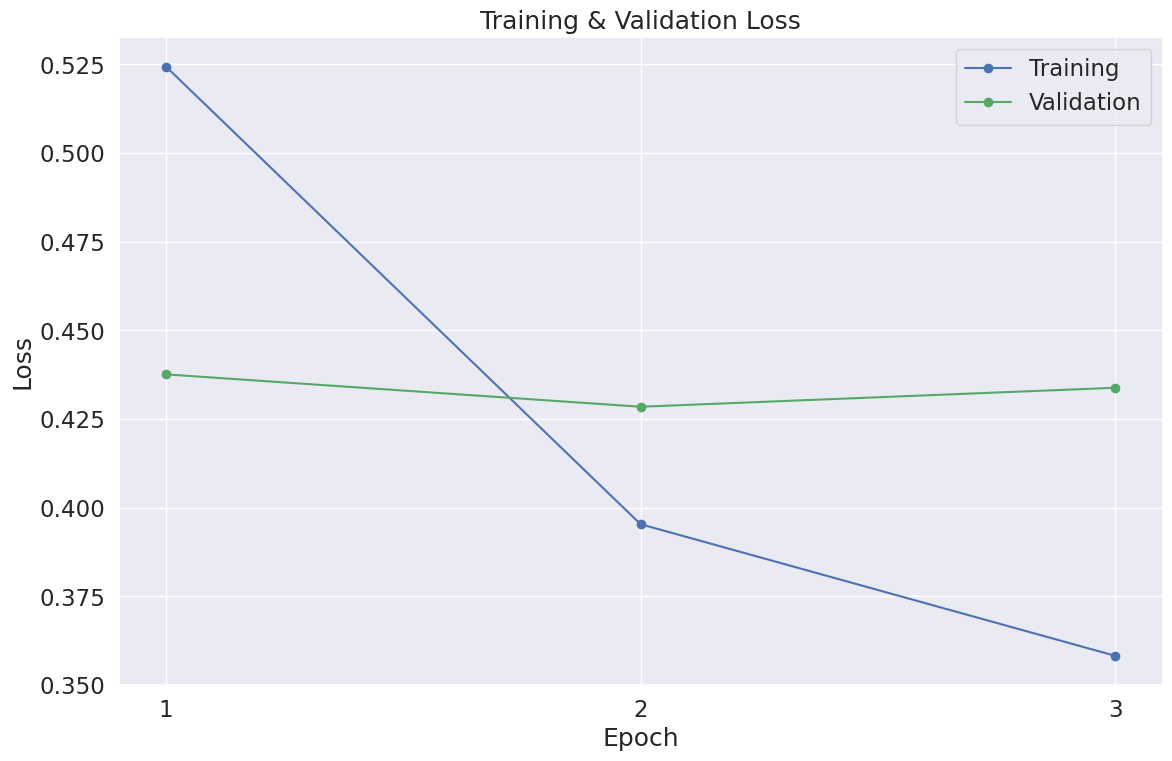

In [35]:
# Increase the plot size and font size:

fig, axes = plt.subplots(figsize=(12,8))

# Plot the learning curve:

plt.plot(df_stats['Training Loss'], 'b-o', label='Training')
plt.plot(df_stats['Valid. Loss'], 'g-o', label='Validation')

# Label the plot:

plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.xticks([1, 2, 3])

plt.show()

In [36]:
print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))
model.eval()
predictions = []
for batch in tqdm(prediction_dataloader):
    batch = tuple(t.to(device) for t in batch)
    batch_input_ids,batch_attention_mask = batch
    
    with torch.no_grad():
        output = model(batch_input_ids,token_type_ids=None,attention_mask=batch_attention_mask)
    logits = output[0]
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)
print('Inference Completed')

Predicting labels for 3,263 test sentences...


  0%|          | 0/102 [00:00<?, ?it/s]

Inference Completed


In [37]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [38]:
submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
submission['target'] = flat_predictions
submission.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [39]:
submission.to_csv('submission.csv',index=False,header=True)